In [7]:
import h5py
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap']='jet'
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
from MD_AE_tools.mode_decomposition import POD


import tensorflow as tf
tf.keras.backend.set_floatx('float32')
import configparser
import MD_AE_tools.ae_mode_evaluation as mode_eval
import MD_AE_tools.models.models_ff as modelff
mse = tf.keras.losses.MeanSquaredError()

from tensorflow.keras.callbacks import ModelCheckpoint
# from MD_AE_tools.models.models import *
from MD_AE_tools.models.models_no_bias import *
from MD_AE_tools.models import model_evaluation
from MD_AE_tools.ae_mode_evaluation import equivalent_pca_energy
from numpy import einsum
from project_specific_utils import my_discrete_cmap, my_continuous_cmap
new_grey = '#C0C0C0'
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=4096)]) # set hard memory limit
        # tf.config.experimental.set_memory_growth(gpus[2], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


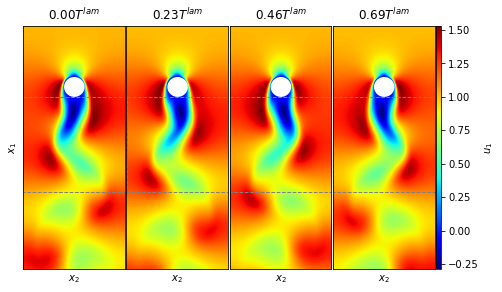

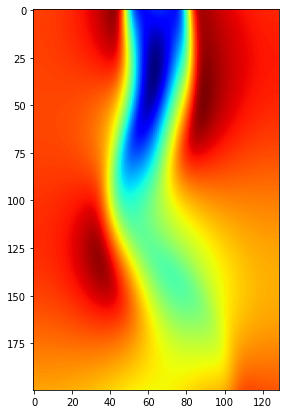

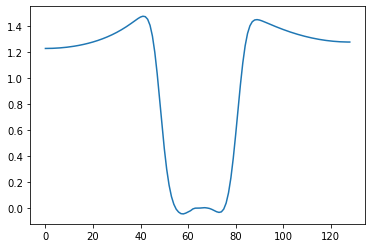

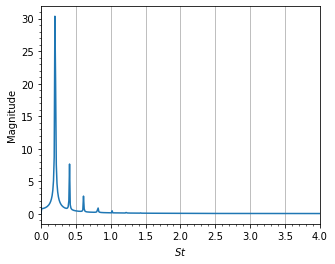

Calculating POD ...
Use snapshot POD, Nx > Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:240: RuntimeWarning: invalid value encountered in sqrt
  Q_POD = (Q@Phi)*(1/(lam**0.5).T)


POD done.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


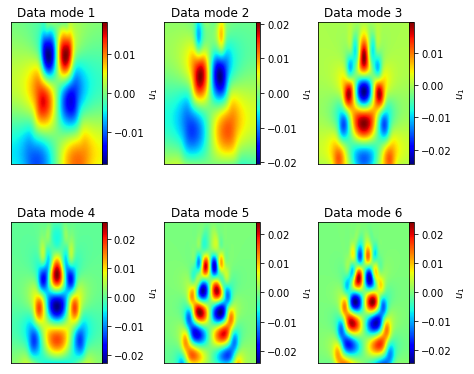

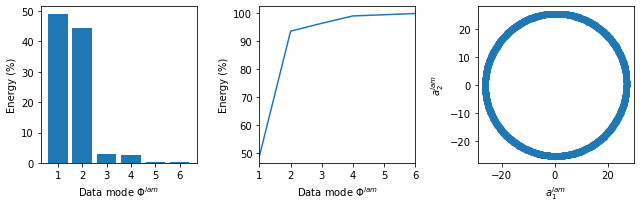

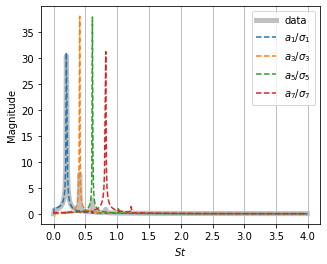

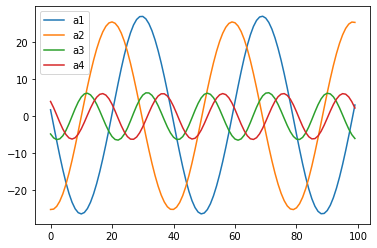

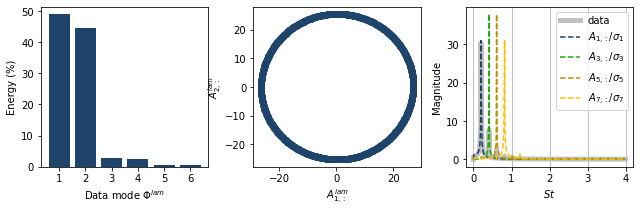

In [18]:
datapath = Path('./data/cylinder/ux.h5')
with h5py.File(datapath,'r') as hf:
    ux = np.array(hf.get('ux'))
realt = np.arange(800)*0.0002*625
realt_as_period = realt/(1/0.23)

fig = plt.figure(figsize=(7,4.5))
grid = ImageGrid(fig,(0.05,0.0,0.83,0.95),(1,4),cbar_mode='single',share_all=True)
for i, ax in enumerate(grid.axes_all):
    im = ax.imshow(ux[i*8,:,:],'jet')
    ax.set(xticks=[],yticks=[],title=f'${realt_as_period[i*8]:.2f}$'+'$T^{lam}$',ylabel='$x_1$',xlabel='$x_2$',aspect=12/20)
    circle = matplotlib.patches.Ellipse((64.5,128.25),26,42,facecolor='white',edgecolor='none')
    domain = matplotlib.patches.Rectangle((0,150),129,200,linewidth=1,edgecolor='grey',facecolor='none',linestyle='--')
    ax.add_patch(domain)
    ax.add_patch(circle)
grid.cbar_axes[0].colorbar(im,label='$u_1$')
# fig.savefig('_plots/cylinder_domain.pdf')

ux = ux[:,150:150+200,:].reshape((800,200,129,1))
plt.figure(figsize=(5,7))
plt.imshow(ux[0,:,:,0])
plt.show()

plt.figure()
plt.plot(ux[0,0,:,0])

## FFT
fftfreq = np.fft.fftfreq(800,0.0002*625)
freq_data = einsum('t x y u -> t',np.abs(np.fft.fft(ux-np.mean(ux,axis=0),axis=0)))
freq_data = freq_data / np.std(freq_data)
plt.figure(figsize=(5,4))
plt.plot(fftfreq[:400],(freq_data*2)[:400])
plt.xlabel('$St$')
plt.ylabel('Magnitude')
plt.minorticks_on()
plt.grid(axis='x')
plt.xlim([0,4.0])
# plt.title('Frequency spectrum of the data')
# plt.savefig('_plots/cylinder_freq.pdf')

plt.show()


pod_data = POD(einsum('t x y -> x y t',np.squeeze(ux)),keep_shape=True)
modes,lam = pod_data.get_modes
a = pod_data.Q.T @ modes.reshape((-1,800))

fig = plt.figure(figsize=(7,6))
grid = ImageGrid(fig,(0.05,0.05,0.8,0.95),(2,3),share_all=True,cbar_mode='each',axes_pad=0.8, cbar_pad=0.0)
for i, (ax,cax) in enumerate(zip(grid,grid.cbar_axes)):
    im = ax.imshow(modes[...,i])
    ax.set(xticks=[],yticks=[],title=f'Data mode {i+1}')
    cax.colorbar(im,label='$u_1$')
# fig.savefig('_plots/cylinder_pod_modes.pdf')


fig,axes = plt.subplots(1,3,figsize=(9,3))
axes[0].bar(range(1,7),100*lam[:6]/np.sum(lam))
axes[0].set(xticks=[1,2,3,4,5,6],xlabel='Data mode $\Phi^{lam}$',ylabel='Energy (%)')
axes[1].plot(range(1,7),100*np.cumsum(lam[:6])/np.sum(lam))
axes[1].set(xticks=[1,2,3,4,5,6],xlabel='Data mode $\Phi^{lam}$',ylabel='Energy (%)',xlim=[1,6])
axes[2].scatter(a[:,0],a[:,1])
axes[2].set(xlabel='$a^{lam}_1$',ylabel='$a^{lam}_2$')
fig.tight_layout()
# fig.savefig('_plots/cylinder_lam.pdf')

# Compare FFT
freq_z = np.abs(np.fft.fft(a-np.mean(a,axis=0),axis=0))
freq_z = freq_z / np.std(freq_z,0)
plt.figure(figsize=(5,4))
plt.plot(fftfreq[:400],(freq_data*2)[:400],c='#C0C0C0',linewidth=5,label='data')
for i in [0,2,4,6]:
    plt.plot(fftfreq[:400],(freq_z[:,i]*2)[:400],'--',label=f'$a_{i+1}$/$\sigma_{i+1}$')
plt.xlabel('$St$')
plt.ylabel('Magnitude')
plt.grid(axis='x')
plt.legend()
# plt.title('Frequency spectrum of the data time coefficients compared with data')
# plt.savefig('_plots/cylinder_coeff_freq.pdf')

plt.figure()
plt.plot(a[:100,0],label='a1')
plt.plot(a[:100,1],label='a2')
plt.plot(a[:100,2],label='a3')
plt.plot(a[:100,3],label='a4')
plt.legend()

fig,axes = plt.subplots(1,3,figsize=(9,3))
fig.tight_layout()
axes[0].bar(range(1,7),100*lam[:6]/np.sum(lam),color=my_discrete_cmap(0))
axes[0].set(xticks=[1,2,3,4,5,6],xlabel='Data mode $\Phi^{lam}$',ylabel='Energy (%)')
axes[1].scatter(a[:,0],a[:,1],c=my_discrete_cmap(0))
axes[1].set_ylabel('$A^{lam}_{2,:}$',labelpad=-0.2)
axes[1].set_xlabel('$A^{lam}_{1,:}$')
plt.subplots_adjust(bottom=0.19)
axes[2].plot(fftfreq[:400],(freq_data*2)[:400],c=new_grey,linewidth=5,label='data')
for i in [0,2,4,6]:
    axes[2].plot(fftfreq[:400],(freq_z[:,i]*2)[:400],'--',label='$A_{'+str(i+1)+',:}$/$\sigma_{'+str(i+1)+'}$',c=my_continuous_cmap(i/6))
axes[2].set_xlabel('$St$')
axes[2].set_ylabel('Magnitude')
axes[2].grid(axis='x')
axes[2].legend()
# plt.savefig('_plots/img_cylinder_pod_results_combined.pdf')

plt.show()

# Define model parameters

In [92]:
Ntrain = 720 # snapshots for training
Nval = 40 # sanpshots for validation
Ntest = 40

# Boolean 
SHUFFLE = True # shuffle before splitting into sets, test set is extracted before shuffling
REMOVE_MEAN = True # train on fluctuating velocity

## ae configuration
lmb = 0.0 #1e-05 #regulariser
drop_rate = 0.0
features_layers = [8, 16, 32]
latent_dim = 3
act_fct = 'tanh'
resize_meth = 'bilinear'
filter_window= (3,3)
batch_norm = False

## feedforward ae configuration
input_shape = ux.size
encoder_layers = [200,200,100]
decoder_layers = [100,200,200]


## training
nb_epoch = 3000
batch_size = 100
learning_rate = 0.001

Nx = 200 # grid size
Ny = 129
Nu = 1
Nt = 800 # number of snapshots available
Nx = [Nx, Ny]

x_mean = np.mean(ux,axis=0,keepdims=True)
x_train = ux[:,:,:,:] - x_mean

# MD-AE

In [21]:
mdae.evaluate(x_train)
mdae.load_weights('_weights/weights_mdae2.h5')

25/25 [==============================] - 1s 3ms/step - loss: 0.0000e+00


In [20]:
mdae = MD_Autoencoder(
    Nx,
    Nu,
    features_layers,
    latent_dim,
    filter_window,
    act_fct='tanh'
)
mdae.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
mdae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 129, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Encoder)              (None, 2)            33034       ['input_1[0][0]']                
                                                                                                  
 z_0 (Lambda)                   (None, 1)            0           ['encoder[0][0]']                
                                                                                                  
 z_1 (Lambda)                   (None, 1)            0           ['encoder[0][0]']            

In [ ]:
loss_mdae = []

In [ ]:
# tempfn_mdae = './temp_weights_mdae.h5'
# model_cb=ModelCheckpoint(tempfn_mdae, monitor='loss',save_best_only=True,verbose=0,save_weights_only=True)
# cb = [model_cb]

# # mdl_linear.load_weights('./_experiments/pre-training-linear-unshuffle-2.h5')
# # Training
# histmdae = mdae.fit(x_train, x_train,
#                 epochs=800,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 callbacks=cb,
#                 verbose=2
# )
# loss_mdae.extend(histmdae.history['loss'])
# mdae.load_weights(tempfn_mdae)
# plt.figure()
# plt.plot(loss_mdae)
# plt.xlabel('epoch')
# plt.ylabel('MSE')
# plt.show()

## Basic analysis

In [22]:
z_mdae = mdae.encoder.predict(x_train)
decomposed_field = []
mdae_decoders = mdae.get_decoders()
for i in range(2):
    decomposed_field.append(
        mdae_decoders[i].predict(z_mdae[:,[i]])
    )
mdae_decomposed = np.array(decomposed_field)[:,:,:,:,0]
y_mdae = mdae.predict(x_train)

In [23]:
mdae_b_post = []
for i in range(2):
    mdae_b_post.append(
        einsum('t x y, x y m', mdae_decomposed[i,...],modes[...,:10])
    )
mdae_b_post = np.array(mdae_b_post)
mdae_b_post.shape

(2, 10, 800)

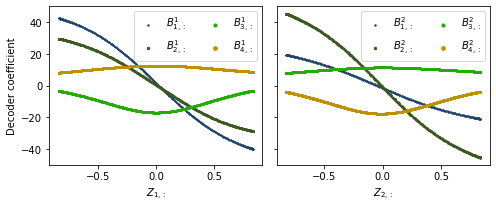

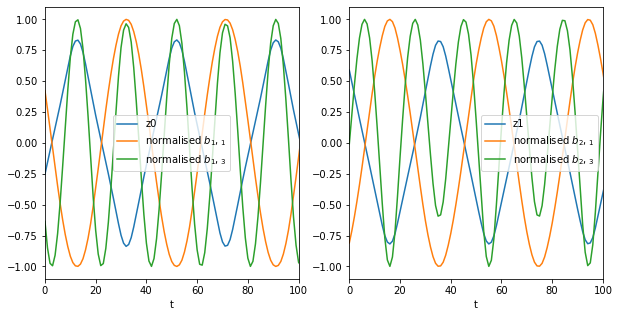

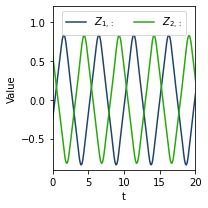

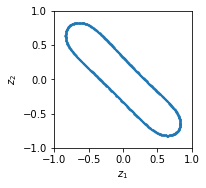

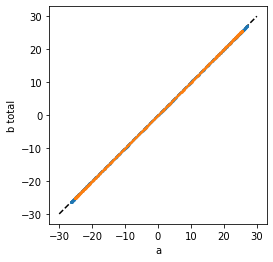

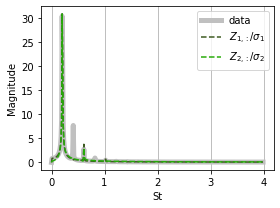

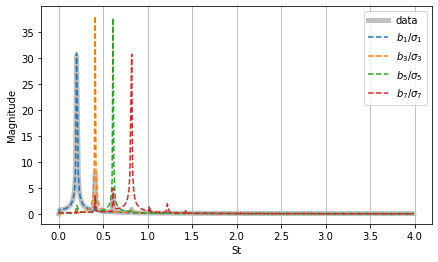

In [46]:
fig,axes = plt.subplots(1,2,figsize=(7,3),sharey=True)
for i in range(2):
    for j in range(4):  
        axes[i].scatter(z_mdae[:,i],mdae_b_post[i,j,:],s=(j+0.5),label='$B^{'+str(i+1)+'}_{'+str(j+1)+',:}$',color=my_discrete_cmap(j))
    axes[i].legend(ncol=2,markerscale=2)
    axes[i].set(xlabel='$Z_{'+str(i+1)+',:}$')
axes[0].set_ylabel('Decoder coefficient')
fig.tight_layout()
# fig.savefig('_plots/img_mdae_cylinder_decodercoeff.pdf')

fig,axes = plt.subplots(1,2,figsize=(10,5))
for i in range(2):
    axes[i].plot(z_mdae[:,i],label=f'z{i}')
    for j in [0,2]:
        axes[i].plot(2*(mdae_b_post[i,j,:]-np.min(mdae_b_post[i,j,:]))/(np.max(mdae_b_post[i,j,:])-np.min(mdae_b_post[i,j,:]))-1,label=f'normalised $b_{i+1},_{j+1}$')
    axes[i].set(xlim=[0,100],xlabel=f't')
    axes[i].legend()

fig3,ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(realt,z_mdae[:,0],label='$Z_{1,:}$',color=my_discrete_cmap(0))
ax.plot(realt,z_mdae[:,1],label='$Z_{2,:}$',color=my_discrete_cmap(2))
ax.set(ylabel='Value',xlim=[0,20],ylim=[-0.9,1.2])
ax.set_xlabel(xlabel='t')
ax.legend(loc='upper center',ncol=2)
fig3.tight_layout()
# fig3.savefig('_plots/img_mdae_cylinder_timetrace.pdf')

fig4,ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(z_mdae[:,0],z_mdae[:,1],s=1)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_aspect('equal')
ax.set(xlim=[-1,1],ylim=[-1,1])
fig4.tight_layout()
# fig4.savefig('_plots/mdae_cylinder_phase.pdf')

mdae_b_total = np.sum(mdae_b_post,axis=0)
_,ax = plt.subplots(1,1)
ax.set(aspect='equal',xlabel='a',ylabel='b total')
ax.scatter(a[:,0],mdae_b_total[0,:],s=1)
ax.scatter(a[:,1],mdae_b_total[1,:],s=1)
ax.plot([-30,30],[-30,30],'k--',zorder=0.1)

# fig,axes = plt.subplots(1,2,figsize=(10,5))
# for i in range(2):
#     for j in range(4):  
#         axes[i].scatter(z_mdae[:,i],mdae_b_total[j,:],s=1,label=f'$b,_{j+1}$')
#     axes[i].legend()
#     axes[i].set(xlabel=f'z{i+1}',ylabel='b')

# Compare FFT of latent variables
freq_z = np.abs(np.fft.fft(z_mdae-np.mean(z_mdae,axis=0),axis=0))
freq_z = freq_z / np.std(freq_z,0)
plt.figure(figsize=(4,3))
plt.plot(fftfreq[:400],(freq_data*2)[:400],c=new_grey,linewidth=5,label='data')
for i in range(latent_dim):
    plt.plot(fftfreq[:400],(freq_z[:,i]*2)[:400],'--',label='$Z_{'+str(i+1)+',:}$/$\sigma_{'+str(i+1)+'}$',color=my_discrete_cmap(int(i+1)))
plt.xlabel('St')
plt.ylabel('Magnitude')
plt.grid(axis='x')
plt.tight_layout()
# plt.title('Frequency spectrum of the latent variables compared with data')
plt.legend()
# plt.savefig('_plots/img_mdae_cylinder_freq.pdf')


# Compare FFT of decoder coefficients
freq_z = np.abs(np.fft.fft(mdae_b_post[0,...]-np.mean(mdae_b_post[0,...],axis=1,keepdims=True),axis=1))
freq_z = freq_z / np.std(freq_z,1).reshape((10,1))
plt.figure(figsize=(7,4))
plt.plot(fftfreq[:400],(freq_data*2)[:400],c='#C0C0C0',linewidth=5,label='data')
for i in [0,2,4,6]:
    plt.plot(fftfreq[:400],(freq_z[i,:]*2)[:400],'--',label=f'$b_{i+1}$/$\sigma_{i+1}$')
plt.xlabel('St')
plt.ylabel('Magnitude')
plt.grid(axis='x')
# plt.title('Frequency spectrum of the latent variables compared with data')
plt.legend()
# plt.savefig('_plots/mdae_cylinder_freq.pdf')

plt.show()

plt.show()

In [47]:
mdae_pod1 = POD(einsum('t x y -> x y t',mdae_decomposed[0,...]),keep_shape=True)
mdae_mode1,mdae_lam1 = mdae_pod1.get_modes
mdae_mode1.shape
mdae_pod2 = POD(einsum('t x y -> x y t',mdae_decomposed[1,...]),keep_shape=True)
mdae_mode2,mdae_lam2 = mdae_pod2.get_modes

Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating POD ...
Use snapshot POD, Nx > Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:240: RuntimeWarning: invalid value encountered in sqrt
  Q_POD = (Q@Phi)*(1/(lam**0.5).T)


POD done.


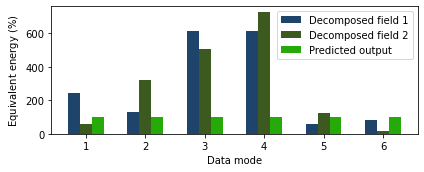

In [52]:
# mdae_eq_energy = []
# for i in range(2):
#     mdae_eq_energy.append(
#         np.diag(mdae_b_post[i,:,:] @ mdae_b_post[i,:,:].T)
#     )
# mdae_eq_energy = np.array(mdae_eq_energy)

mdae_eq_energy = equivalent_pca_energy(mdae_decomposed[:,:,:,:,np.newaxis], modes.reshape((200*129,-1))[:,:6])
percent_mdae_eq_energy = 100*(mdae_eq_energy/np.reshape(lam[:6],(1,6)))
mdae_eq_energy_y = equivalent_pca_energy(y_mdae[np.newaxis,:,:,:], modes.reshape((200*129,-1))[:,:6])
percent_mdae_eq_energy_y = 100*(mdae_eq_energy_y/np.reshape(lam[:6],(1,6)))



plt.figure(figsize=(6,2.5))
plt.bar(np.arange(1,7)-0.2, percent_mdae_eq_energy[0,:],width=0.2, label='Decomposed field 1',color=my_discrete_cmap(0))
plt.bar(np.arange(1,7)+0.0, percent_mdae_eq_energy[1,:],width=0.2, label='Decomposed field 2',color=my_discrete_cmap(1))
plt.bar(np.arange(1,7)+0.2, percent_mdae_eq_energy_y[0,:],width=0.2, label='Predicted output',color=my_discrete_cmap(2))
plt.legend()
plt.ylabel('Equivalent energy ($\\%$)')
plt.xlabel('Data mode')
plt.tight_layout()
# plt.savefig('_plots/img_mdae_cylinder_equivalent_energy.pdf')
plt.show()


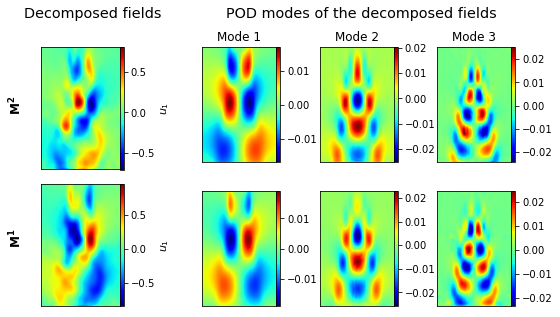

In [49]:
fig = plt.figure(figsize=(8,4.5))
# ax1 = ImageGrid(fig,122,(2,4),axes_pad=(0.5,0.4), cbar_location='right', cbar_mode='each', cbar_pad=0.03, share_all=True)
# ax2 = ImageGrid(fig,141,(2,1),axes_pad=(0.5,0.2), cbar_location='right', cbar_mode='each', cbar_pad=0.03, share_all=True)
ax1 = ImageGrid(fig,(0.28,0.05,0.7,0.8),(2,3),axes_pad=(0.55,0.4), cbar_location='right', cbar_mode='each', cbar_pad=0.0, share_all=True)
ax2 = ImageGrid(fig,(0.05,0.05,0.2,0.8),(2,1),axes_pad=(0.5,0.2), cbar_location='right', cbar_mode='each', cbar_pad=0.0, share_all=True)
fig.text(0.4,0.94,'POD modes of the decomposed fields',fontsize='x-large')
fig.text(0.05,0.94,'Decomposed fields',fontsize='x-large')

fig.text(0.02,0.24,'$\\bf{M}^1$',rotation=90,fontsize='large')
fig.text(0.02,0.65,'$\\bf{M}^2$',rotation=90,fontsize='large')

cax1 = ax1.cbar_axes
cax2 = ax2.cbar_axes
im1 = ax2[0].imshow(mdae_decomposed[0,0,...],'jet')
# ax2[0].set_ylabel('v')
cax2[0].colorbar(im1).set_label(label='$u_1$',size=11)
im2 = ax2[1].imshow(mdae_decomposed[1,0,...],'jet')
# ax2[1].set_ylabel('w')
cax2[1].colorbar(im2).set_label(label='$u_1$',size=11)
ax2[1].set(yticks=[],xticks=[])

for i in range(3):
    im1 = ax1[i].imshow(mdae_mode1[...,i],'jet')
    cax1[i].colorbar(im1)
    ax1[i].set_title(f'Mode {i+1}')
    # ax1[i].set_title(f'mode {i+1},\nenergy={percent_lam_v[i]:.1f}%')
    im2 = ax1[i+3].imshow(mdae_mode2[...,i],'jet')
    cax1[i+3].colorbar(im2)
ax1[0].set(yticks=[],xticks=[])

# fig.savefig('_plots/mdae_cylinder_podofdecomposed.pdf')
plt.show()

# Standard AE

In [94]:
ae = Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,
        act_fct=act_fct,
        batch_norm=batch_norm,
        drop_rate=drop_rate, 
        lmb=lmb,
        # encoder_kwargs={'last_act':'tanh'},
        # decoder_kwargs={'first_act':tf.math.sin}
)
ae.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 200, 129, 1)]     0         
                                                                 
 encoder_3 (Encoder)         (None, 3)                 46635     
                                                                 
 decoder_2 (Decoder)         (None, 200, 129, 1)       60232     
                                                                 
Total params: 106,867
Trainable params: 106,867
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_ae = []

In [95]:
ae.compile(optimizer=Adam(learning_rate=0.0001),loss='mse')
ae.evaluate(x_train,x_train)
ae.load_weights('./_weights/weights_ae3.h5')
ae.evaluate(x_train,x_train)

25/25 [==============================] - 0s 8ms/step - loss: 2.7221e-06


2.7221481104788836e-06

In [56]:
# tempfn_ae = './temp_weights_ae.h5'
# model_cb=ModelCheckpoint(tempfn_ae, monitor='loss',save_best_only=True,verbose=0,save_weights_only=True)
# cb = [model_cb]

# # ae.load_weights('./_experiments/pre-training-linear-unshuffle-2.h5')
# # Training
# histae = ae.fit(x_train, x_train,
#                 epochs=4000,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 callbacks=cb,
#                 verbose=2
# )
# loss_ae.extend(histae.history['loss'])
# ae.load_weights(tempfn_ae)
# plt.figure()
# plt.semilogy(loss_ae)
# plt.xlabel('epoch')
# plt.ylabel('MSE')
# plt.show()
# print(np.mean(loss_ae[-100:]))

In [ ]:
# np.save('_results/loss_nz4',loss_ae)

## Basic analysis

In [93]:
def get_b_hold_z1_constant(y_i,modes):
    b_i = jnp.einsum('t x y, x y m -> t m', jnp.squeeze(y_i),modes)
    return b_i


def get_dbdz_for_observed(b_real,z):

    '''b_real has shape [t,modes], z has shape [t, latent_dim]'''

    db_allt = b_real[1:,:] - b_real[:-1,:] #[t,modes]
    dz_allt = z[1:,:] - z[:-1,:] #[t,latent_dim]
    def get_dbdzi_t(db,dz):
        return db/dz #[modes]
    get_dbdz_t = jax.vmap(get_dbdzi_t,in_axes=(0,None),out_axes=0) #[mode,latent_dim]

    get_dbdz = jax.vmap(get_dbdz_t,in_axes=(0,0),out_axes=0)

    return get_dbdz(db_allt,dz_allt)

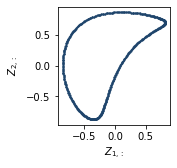

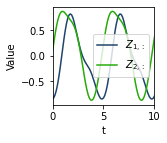

In [96]:
z_ae = ae.encoder.predict(x_train)
ae_pred = np.squeeze(ae.predict(x_train))
fig,ax1 = plt.subplots(1,1,figsize=(2.5,2.5))
ax1.scatter(z_ae[:,0],z_ae[:,1],s=1,color=my_discrete_cmap(0))
ax1.set(aspect='equal',xlabel='$Z_{1,:}$',ylabel='$Z_{2,:}$')
fig.tight_layout()
# fig.savefig('./_plots/img_ae_cylinder2_phase.pdf',bbox_inches='tight')

fig,ax2 = plt.subplots(1,1,figsize=(2.5,2.5))
ax2.plot(realt,z_ae[:,0],label='$Z_{1,:}$',color=my_discrete_cmap(0))
ax2.plot(realt,z_ae[:,1],label='$Z_{2,:}$',color=my_discrete_cmap(2))
ax2.set(xlabel='t',ylabel='Value')
ax2.legend()
ax2.set(xlim=[0,10])
plt.tight_layout()
ax2.set_aspect(5)
# plt.savefig('_plots/img_ae_cylinder2_latentbasic_timetrace.pdf',bbox_inches='tight')
plt.show()

In [63]:
ae_b_post_real = einsum('t x y, x y m -> t m', ae_pred, modes[...,:6])

## 2D

In [64]:
z1 = np.linspace(-0.99,0.99,101).astype('float32')
z2 = np.linspace(-0.99,0.99,101).astype('float32')
idx_z2_0 = np.squeeze(np.argwhere(np.abs(z2-0)<1.19209e-07))
idx_z1_0 = np.squeeze(np.argwhere(np.abs(z1-0)<1.19209e-07))
print(idx_z1_0,idx_z2_0)
zx,zy = np.meshgrid(z1,z2)


50 50


In [65]:
_y_grid =[]
for i in range(len(z1)):
    y_i = ae.decoder.predict(
        tf.stack((zx[:,i],zy[:,0]),axis=1)
    )
    _y_grid.append(y_i)
_y_grid = np.array(_y_grid)

v_get_b_gridded = jax.vmap(get_b_hold_z1_constant,in_axes=(0,None))
ae_b_post_gridded = v_get_b_gridded(_y_grid,modes[...,:6]) #[z1,z2,modes]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
# ae_b_post_gridded = []
# for i in range(len(z1)):
#     y_i = ae.decoder.predict(
#         np.stack((zx[:,i],zy[:,0]),axis=1)
#     )
#     b_i = einsum('t x y, x y m -> t m', np.squeeze(y_i),modes[...,:6])
#     ae_b_post_gridded.append(b_i)
# ae_b_post_gridded = np.array(ae_b_post_gridded)#[num z1, num z2, m]

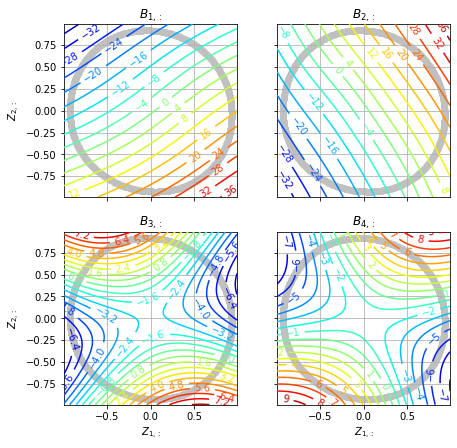

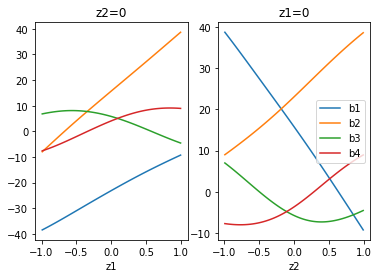

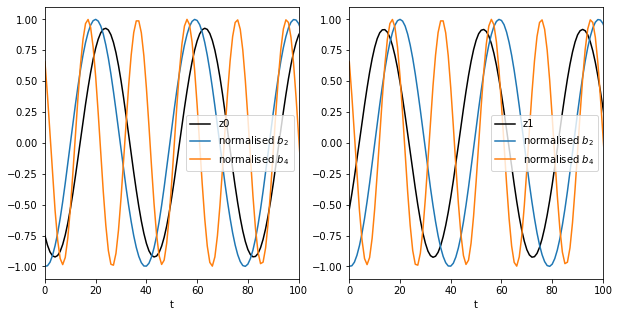

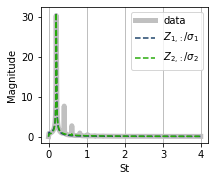

In [76]:
fig,ax = plt.subplots(2,2,figsize=(7,7),sharex=True,sharey=True)
ax_flat = ax.flatten()
for i in range(4):
    cs = ax_flat[i].contour(zx,zy,ae_b_post_gridded[:,:,i].T,levels=20,zorder=5)
    ax_flat[i].clabel(cs)
    ax_flat[i].grid()
    ax_flat[i].scatter(z_ae[:,0],z_ae[:,1],zorder=1,c='#C0C0C0',alpha=0.5)
    ax_flat[i].set_aspect('equal')
ax_flat[2].set(xlabel='$Z_{1,:}$',ylabel='$Z_{2,:}$')
ax_flat[0].set(ylabel='$Z_{2,:}$')
ax_flat[3].set(xlabel='$Z_{1,:}$')
ax_flat[0].set_title('$B_{1,:}$',fontsize='large')
ax_flat[1].set_title('$B_{2,:}$',fontsize='large')
ax_flat[2].set_title('$B_{3,:}$',fontsize='large')
ax_flat[3].set_title('$B_{4,:}$',fontsize='large')
# fig.savefig('_plots/ae_cylinder2_contour.pdf')

## plot b(zi) where zj (j\=i) is held at zero
fig,axes = plt.subplots(1,2)
axes[0].set(title='z2=0',xlabel='z1')
axes[0].plot(z1,ae_b_post_gridded[:,440,0],label='b1')
axes[0].plot(z1,ae_b_post_gridded[:,440,1],label='b2')
axes[0].plot(z1,ae_b_post_gridded[:,440,2],label='b3')
axes[0].plot(z1,ae_b_post_gridded[:,440,3],label='b4')

axes[1].set(title='z1=0',xlabel='z2')
axes[1].plot(z2,ae_b_post_gridded[430,:,0],label='b1')
axes[1].plot(z2,ae_b_post_gridded[430,:,1],label='b2')
axes[1].plot(z2,ae_b_post_gridded[430,:,2],label='b3')
axes[1].plot(z2,ae_b_post_gridded[430,:,3],label='b4')
axes[1].legend()

## plot z with b against time
fig,axes = plt.subplots(1,2,figsize=(10,5))
for i in range(2):
    axes[i].plot(z_ae[:,i],label=f'z{i}',c='k')
    for j in [1,3]:
        axes[i].plot(2*(ae_b_post_real[:,j]-np.min(ae_b_post_real[:,j]))/(np.max(ae_b_post_real[:,j])-np.min(ae_b_post_real[:,j]))-1,label=f'normalised $b_{j+1}$')
    axes[i].set(xlim=[0,100],xlabel=f't')
    axes[i].legend()

# Compare FFT
z_colour = (my_discrete_cmap(0),my_discrete_cmap(2),my_discrete_cmap(3))
freq_z = np.abs(np.fft.fft(z_ae-np.mean(z_ae,axis=0),axis=0))
freq_z = freq_z / np.std(freq_z,0)
plt.figure(figsize=(3,2.5))
plt.plot(fftfreq[:400],(freq_data*2)[:400],c=new_grey,linewidth=5,label='data')
for i in range(latent_dim):
    plt.plot(fftfreq[:400],(freq_z[:,i]*2)[:400],'--',label='$'+'Z_{'+str({i+1})+',:}$/$\sigma_{'+str(i+1)+'}$',color=z_colour[i])
plt.xlabel('St')
plt.ylabel('Magnitude')
plt.grid(axis='x')
plt.legend()
# plt.title('Frequency spectrum of the latent variables compared with data')
# plt.savefig('./_plots/img_ae_cylinder2_freq.pdf',bbox_inches='tight')


plt.show()

## using gradients

How much $B_j$ varies with $z_i$.

$\int \int | \frac{dB_j}{dz_i}| dz_1 dz_2 / (range(z_1) \times range(z_2))$

when calculating with discrete values and equal intervals, this is 

$\epsilon = \sum_{z_1,z_2} | \frac{dB_j}{dz_i} | / (N_{z_1} N_{z_2})$
average absolute rate of change of decoder coefficients due to the latent variables 

In [77]:
#b_gridded as shape [num z1, num z2, m]
ae_dbdz = []
ae_dbdz.append(np.gradient(ae_b_post_gridded,z1[1]-z1[0],axis=0,edge_order=2))
ae_dbdz.append(np.gradient(ae_b_post_gridded,z2[1]-z2[0],axis=1,edge_order=2))
ae_dbdz = ae_dbdz

In [78]:
avgbz1 = np.mean(np.abs(ae_dbdz[0]),(0,1)) # this is assuming dbdz has shape[z1,z2,modes]
avgbz2 = np.mean(np.abs(ae_dbdz[1]),(0,1))

/tmp/ipykernel_1163765/3895077303.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticks=[], xticklabels=np.arange(0,7))


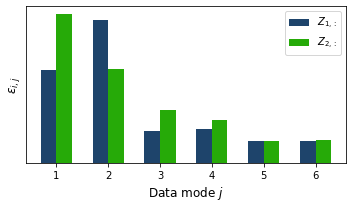

In [81]:
fig,ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(1,7)-0.15,avgbz1[:6],width=0.3,label='$Z_{1,:}$',color=z_colour[0])
ax.bar(np.arange(1,7)+0.15,avgbz2[:6],width=0.3,label='$Z_{2,:}$',color=z_colour[1])
ax.set(yticks=[], xticklabels=np.arange(0,7))
ax.set_ylabel(ylabel='$\epsilon_{i,j}$',fontsize='large')
ax.set_xlabel(xlabel='Data mode $j$',fontsize='large')
ax.legend()
fig.tight_layout()
# plt.title('averged_absolute_rate_of_change')
# fig.savefig('_plots/img_ae_cylinder2_rateofchange.pdf')
plt.show()


## 3D

In [97]:
z1 = np.linspace(-0.99,0.99,101).astype('float32')
z2 = np.linspace(-0.99,0.99,101).astype('float32')
idx_z2_0 = np.squeeze(np.argwhere(np.abs(z2-0)<1.19209e-07))
idx_z1_0 = np.squeeze(np.argwhere(np.abs(z1-0)<1.19209e-07))
print(idx_z1_0,idx_z2_0)
z3 = np.linspace(-0.99,0.99,101).astype('float32')
idx_z3_0 = np.squeeze(np.argwhere(np.abs(z3-0)<1.19209e-07))
zx,zy,zz = np.meshgrid(z1,z2,z3)

50 50


In [98]:
## latent_dim = 3
_y_grid = []
for i in range(len(z1)):
    _y_grid_i = []
    for j in range(len(z2)):
        y_ij = ae.decoder.predict(
            tf.stack((zx[:,i,i],zy[j,:,j],zz[0,0,:]),axis=1),
            batch_size=batch_size
        )
        _y_grid_i.append(y_ij)
    _y_grid.append(_y_grid_i)
_y_grid = jnp.array(_y_grid)

v_get_b_gridded = jax.vmap(get_b_hold_z1_constant,in_axes=(0,None))
vv_get_b_gridded = jax.vmap(v_get_b_gridded,in_axes=(0,None))
ae_b_post_gridded = vv_get_b_gridded(_y_grid,modes[...,:6]) #[z1,z2,z3,modes]

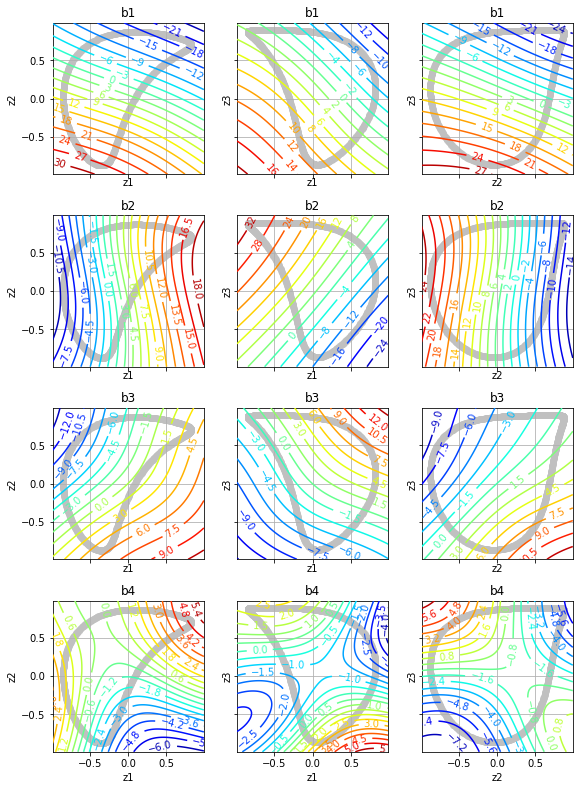

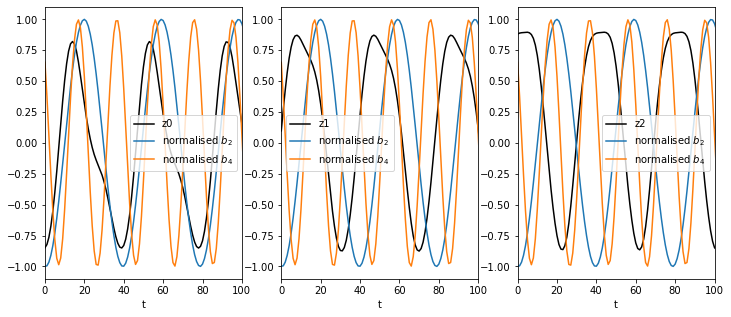

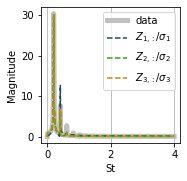

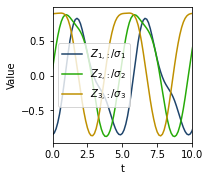

In [99]:
idx = [[0,1],[0,2],[1,2]]
fig,ax = plt.subplots(4,3,figsize=(8,11),sharex=True,sharey=True)
fig.tight_layout()
for i in range(4):
    cs = ax[i,0].contour(zx[:,:,0],zy[:,:,0],ae_b_post_gridded[:,:,idx_z3_0,i].T,levels=20,zorder=5)
    ax[i,0].clabel(cs)
    ax[i,0].grid()
    ax[i,0].set_title(f'b{i+1}')
    ax[i,0].scatter(z_ae[:,0],z_ae[:,1],zorder=1,c='#C0C0C0',alpha=0.5)
    ax[i,0].set(xlabel='z1',ylabel='z2')

    cs = ax[i,1].contour(zx[0,:,:],zz[0,:,:],ae_b_post_gridded[:,idx_z2_0,:,i].T,levels=20,zorder=5)
    ax[i,1].clabel(cs)
    ax[i,1].grid()
    ax[i,1].set_title(f'b{i+1}')
    ax[i,1].scatter(z_ae[:,0],z_ae[:,2],zorder=1,c='#C0C0C0',alpha=0.5)
    ax[i,1].set(xlabel='z1',ylabel='z3')

    cs = ax[i,2].contour(zy[:,0,:],zz[:,0,:],ae_b_post_gridded[idx_z1_0,:,:,i].T,levels=20,zorder=5)
    ax[i,2].clabel(cs)
    ax[i,2].grid()
    ax[i,2].set_title(f'b{i+1}')
    ax[i,2].scatter(z_ae[:,1],z_ae[:,2],zorder=1,c='#C0C0C0',alpha=0.5)
    ax[i,2].set(xlabel='z2',ylabel='z3')


for axis in ax.flatten():
    axis.set_aspect('equal')
# fig.savefig('_plots/ae_cylinder3_contours.pdf')


ae_b_post_real = einsum('t x y, x y m -> t m', ae_pred, modes[...,:6])
fig,axes = plt.subplots(1,3,figsize=(12,5))
for i in range(3):
    axes[i].plot(z_ae[:,i],label=f'z{i}',c='k')
    for j in [1,3]:
        axes[i].plot(2*(ae_b_post_real[:,j]-np.min(ae_b_post_real[:,j]))/(np.max(ae_b_post_real[:,j])-np.min(ae_b_post_real[:,j]))-1,label=f'normalised $b_{j+1}$')
    axes[i].set(xlim=[0,100],xlabel=f't')
    axes[i].legend()


freq_z = np.abs(np.fft.fft(z_ae-np.mean(z_ae,axis=0),axis=0))
freq_z = freq_z / np.std(freq_z,axis=0)
plt.figure(figsize=(2.5,2.5))
plt.plot(fftfreq[:400],(freq_data*2)[:400],c='#C0C0C0',linewidth=5,label='data')
for i in range(latent_dim):
    plt.plot(fftfreq[:400],(freq_z[:,i]*2)[:400],'--',label='$Z_{'+str(i+1)+',:}$/$\sigma_{'+str(i+1)+'}$',color=z_colour[i])
plt.xlabel('St')
plt.ylabel('Magnitude')
plt.grid(axis='x')
plt.legend()
# plt.savefig('_plots/img_ae_cylinder3_freq.pdf',bbox_inches='tight')
# plt.title('Nomralised frequency spectrum of latent variables compared against data')


plt.figure(figsize=(2.5,2.5))
for i in range(latent_dim):
    plt.plot(realt,z_ae[:,i],label='$Z_{'+str(i+1)+',:}$/$\sigma_{'+str(i+1)+'}$',color=z_colour[i])
plt.xlim([0,10])
plt.xlabel('t')
plt.ylabel('Value')
plt.legend()
# plt.savefig('_plots/img_ae_cylinder3_timetrace.pdf',bbox_inches='tight')


plt.show()

/tmp/ipykernel_1163765/1944972891.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticks=[], xticklabels=np.arange(0,7))


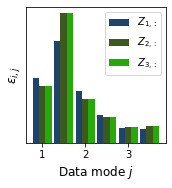

In [101]:
ae_dbdz = []
ae_dbdz.append(np.gradient(ae_b_post_gridded,z1[1]-z1[0],axis=0,edge_order=2))
ae_dbdz.append(np.gradient(ae_b_post_gridded,z2[1]-z2[0],axis=1,edge_order=2))
ae_dbdz.append(np.gradient(ae_b_post_gridded,z3[1]-z3[0],axis=2,edge_order=2))

avgbz1 = np.mean(np.abs(ae_dbdz[0]),(0,1,2)) # this is assuming dbdz has shape[z1,z2,z3,modes]
avgbz2 = np.mean(np.abs(ae_dbdz[1]),(0,1,2))
avgbz3 = np.mean(np.abs(ae_dbdz[2]),(0,1,2))

fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.bar(np.arange(0,6)-0.3,avgbz1[:6],width=0.3,label='$Z_{1,:}$',color=my_discrete_cmap(0))
ax.bar(np.arange(0,6),avgbz3[:6],width=0.3,label='$Z_{2,:}$',color=my_discrete_cmap(1))
ax.bar(np.arange(0,6)+0.3,avgbz3[:6],width=0.3,label='$Z_{3,:}$',color=my_discrete_cmap(2))
ax.set(yticks=[], xticklabels=np.arange(0,7))
ax.set_ylabel(ylabel='$\epsilon_{i,j}$',fontsize='large')
ax.set_xlabel(xlabel='Data mode $j$',fontsize='large')
ax.legend()
# plt.title('averged absolute rate of change for all valid AE values')
# fig.savefig('_plots/img_ae_cylinder3_rateofchange.pdf',bbox_inches='tight')
plt.show()

## 1D

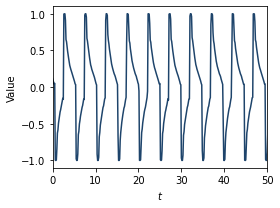

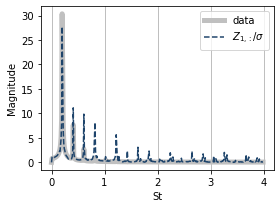

In [91]:
z_ae = ae.encoder.predict(x_train)
ae_pred = np.squeeze(ae.predict(x_train))
plt.figure(figsize=(4,3))
plt.plot(realt,z_ae[:,0],color=z_colour[0])
plt.xlabel('$t$')
plt.ylabel('Value')
plt.xlim([0,50])
plt.tight_layout()
# plt.savefig('_plots/img_ae_cylinder1_timetrace.pdf')
plt.show()

# Compare FFT
freq_z = np.abs(np.fft.fft(z_ae[:,0]-np.mean(z_ae[:,0])))
freq_z = freq_z / np.std(freq_z)
plt.figure(figsize=(4,3))
plt.plot(fftfreq[:400],(freq_data*2)[:400],c=new_grey,linewidth=5,label='data')
plt.plot(fftfreq[:400],(freq_z*2)[:400],'--',label='$Z_{1,:}$/$\sigma$',color=z_colour[0])
plt.ylabel('Magnitude')
plt.xlabel('St')
plt.tight_layout()
plt.grid(axis='x')
plt.legend()
# plt.savefig('_plots/img_ae_cylinder1_freq.pdf',bbox_inches='tight')
# plt.title('Frequency spectrum of the latent variables compared with data')
plt.show()

In [ ]:
ae_b_post = einsum('t x y, x y m -> t m', ae_pred, modes[...,:10])

fig,ax = plt.subplots(1,2,figsize=(10,4))
for i in range(4):
    ax[0].scatter(z_ae[:,0],ae_b_post[:,i],s=1,label=f'$b_{i+1}$')
    ax[0].legend()
    ax[0].set(xlabel=f'z',ylabel='b')
ax[1].plot(z_ae[:,0],label='z')
for i in [1,3]:
    ax[1].plot(2*(ae_b_post[:,i]-np.min(ae_b_post[:,i]))/(np.max(ae_b_post[:,i])-np.min(ae_b_post[:,i]))-1,label=f'normalised $b_{i+1}$')
ax[1].set(xlim=[0,100],xlabel=f't')
ax[1].legend()
plt.show()

# Converegence

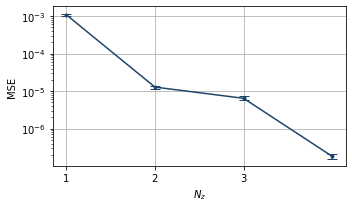

In [71]:
loss1 = [0.0011096448672469705,0.0010053587454603985,0.0011171308858320117,0.0011992743762675672,0.0010219239944126456]
loss2 = [1.1017092724614485e-05,1.442833188775694e-05,1.2543165239549125e-05,1.410638949892018e-05,1.2011425615128247e-05]
loss3 = [5.494603158240352e-06,6.30100856142235e-06,6.46826547153978e-06,7.828100301594531e-06,6.049606215583481e-06]
loss4 = [1.4271620884187542e-07, 1.7713642549210818e-07,1.8907969078441057e-07,2.1865492215056292e-07,1.819371135525216e-07]

loss_repeat = np.stack((loss1,loss2,loss3,loss4),axis=0)
loss_std = np.std(loss_repeat,axis=1)
loss_mean = np.mean(loss_repeat,axis=1)

fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.errorbar([1,2,3,4],loss_mean,yerr=loss_std,capsize=5,fmt='.-',color=my_discrete_cmap(0))
ax.set(xlabel='$N_z$',ylabel='MSE',xticks=[1,2,3])
ax.set_yscale('log')
ax.grid('both')
fig.tight_layout()
fig.savefig('_plots/img_ae_cylinder_converegence.pdf')
plt.show()

In [72]:
loss_mean[1]

1.2821280993193796e-05

# Too slow, but may be useful

In [ ]:
# batch_size = 2
# ae_dydz = []
# tf.keras.backend.set_floatx('float16')
# print(tf.keras.backend.floatx())

# # hold z1 constant, change z2
# def derivative2(batch_size):
#     ae_dydz = []
#     for i in range(len(z1)):
#         ae_dydz_i = []
#         t = 0
#         # for j in range(len(z2)):
#         while (t+batch_size) < len(z2):

#             # print(f'in this batch t={t} to {t+batch_size}')
#             # print(tf.stack([zx[t:t+batch_size,i],zy[t:t+batch_size,0]],axis=1)[:3,...])

#             gradients = model_evaluation.get_gradient_m_z(
#                 tf.stack([zx[t:t+batch_size,i],zy[t:t+batch_size,0]],axis=1),
#                 ae.decoder
#             ) # [batch,....,z]

#             ae_dydz_i.append(gradients)

#             t = t + batch_size
        
#         # print(f'in this batch t={t} to {len(z2)}')
#         gradients = model_evaluation.get_gradient_m_z(tf.stack([zx[t:,0],zy[t:,0]],axis=1),ae.decoder) 

#         ae_dydz_i.append(gradients)

#         ae_dydz.append(tf.concat(ae_dydz_i,axis=0))
#     return ae_dydz
    

# # ae_dydz = np.array(ae_dydz) # (no.of z1, z2, ny, nz, nu, latent_dim)

In [ ]:
# ae_dydz = derivative2(batch_size)

In [ ]:
# def get_dB_dz(dy_dz,pod_modes):
#     dy_dz_vector = []
#     dy_dz_temp = einsum('k t y z u -> k y z t u', dy_dz) # rearrange the same way as preparing for pod

#     for i in range(dy_dz.shape[0]):
#         # dy_dz_reshape = np.vstack((dy_dz_temp[i,:,:,:,0], dy_dz_temp[i,:,:,:,1]))
#         dy_dz_reshape = np.reshape(dy_dz_reshape,(-1, dy_dz.shape[1]))
#         dy_dz_vector.append(dy_dz_reshape)

#     dy_dz_vector = np.array(dy_dz_vector) # shape[no of z1,modes,no of z2]

#     dB_dz = []
#     for i in range(dy_dz.shape[0]):
#         dB_dz.append(pod_modes.T @ dy_dz_vector[i,...])
#     dB_dz = np.array(dB_dz) # [no of z1, modes, no of z2]
    
#     return dB_dz

In [ ]:
# ae_dbdz = []
# for i in range(2):
#     ae_dbdz.append(
#         get_dB_dz(ae_dydz[...,1],modes.reshape((200*129,-1)))
#     )